In [19]:
# Import stuff: 
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sympy import Symbol
from sympy.solvers import solve

# This is for reasonable fontsize universally defined:
fs_label = 16
parameters = {                
                'figure.titlesize': fs_label+6,
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.linewidth': 5
             }
plt.rcParams.update(parameters)

In [20]:
# Parameters: 
# TODO: use the real values
params_dict = dict(
    g1 = 0.5, # zygote
    g2 = 0.8, # planula
    g3 = 0.7, # cyst
    g4 = 0.8, # polyp
    g5 = 0.8, # medusa (juvenile)
    g6 = 0.8, # medusa (mature)
    phi = 10, 
    xi = 0
)
params_dict.update(
    h12 = (1 - params_dict["g1"])*0.2, 
    h24 = (1 - params_dict["g2"])*0.2, 
    h34 = (1 - params_dict["g3"])*0.2, 
    h45 = (1 - params_dict["g4"])*10, 
    h56 = (1 - params_dict["g5"])*0.8, 
)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)

g1 = 0.5
g2 = 0.8
g3 = 0.7
g4 = 0.8
g5 = 0.8
g6 = 0.8
phi = 10
xi = 0
h12 = 0.1
h24 = 0.039999999999999994
h34 = 0.06000000000000001
h45 = 1.9999999999999996
h56 = 0.15999999999999998


No handles with labels found to put in legend.
No handles with labels found to put in legend.


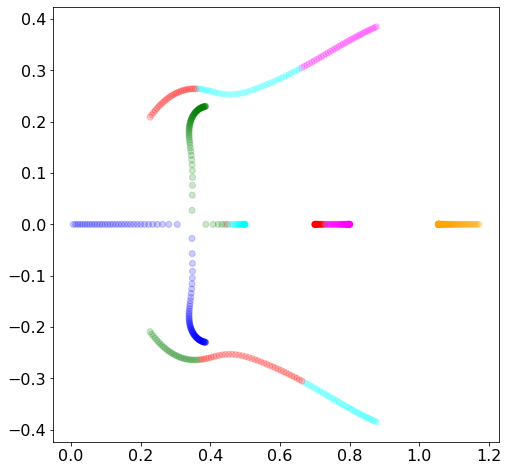

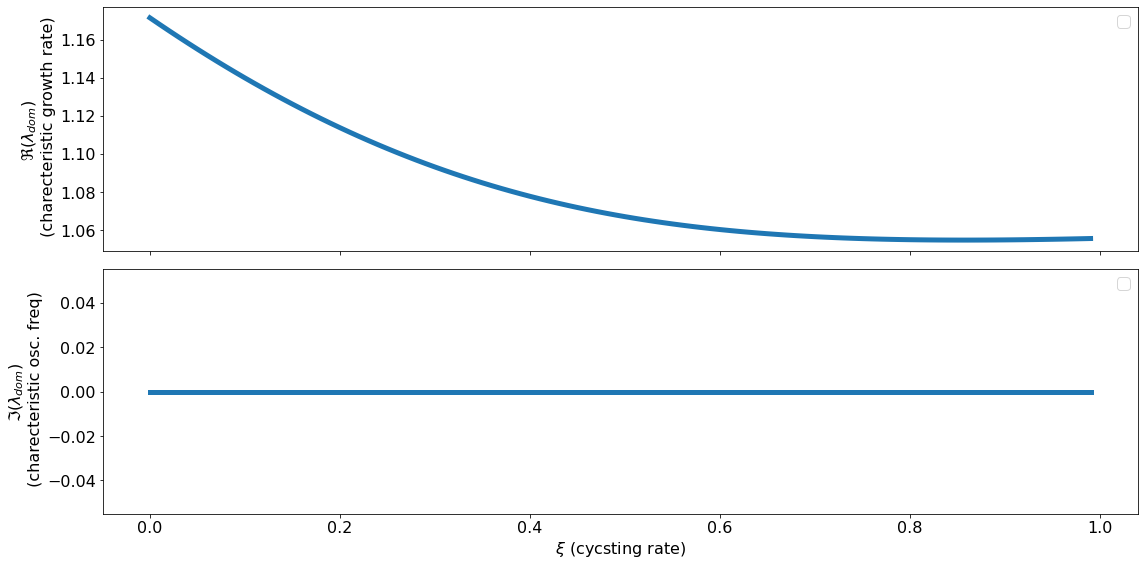

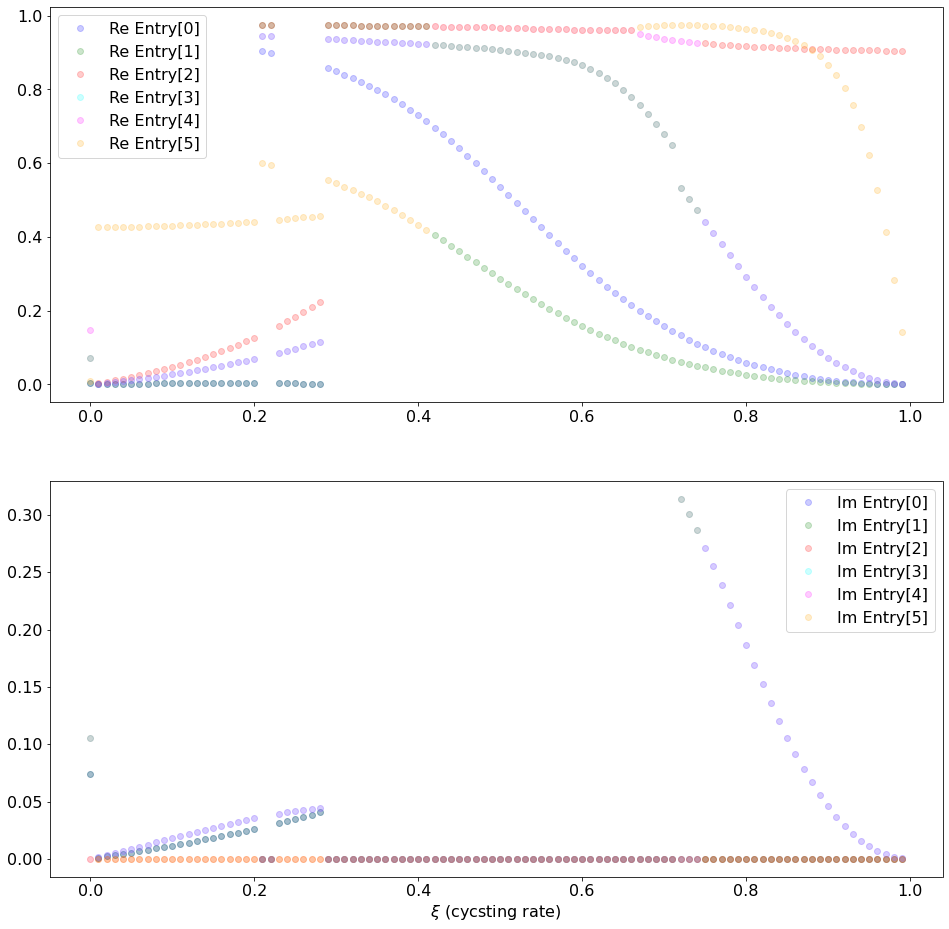

In [56]:
L = lambda xi: np.array([
    [g1,  0,   0,   0,   0,          phi*(1-xi)], 
    [h12, g2,  0,   0,   0,          0], 
    [0,   0,   g3,  0,   g5*xi,      g6*xi], 
    [0,   h24, h34, g4,  0,          0], 
    [0,   0,   0,   h45, g5*(1-xi),  0], 
    [0,   0,   0,   0,   h56*(1-xi), g6*(1-xi)]
])

fig, ax = plt.subplots(figsize=(8, 8))
cs = ["blue", "green", "red", "cyan", "magenta", "orange"]
ss = []
gr = []
xis = np.arange(0.00, 1, 0.01)
for xi in xis:
    eig_values, eig_vectors = np.linalg.eig(L(xi))
    isort = np.argsort([abs(z) + (z.imag)/100 for z in eig_values])
    ss.append(eig_vectors[isort[-1]])
    gr.append(eig_values[isort[-1]])
    ax.scatter(*list(zip(*[(z.real, z.imag) for z in eig_values[isort]])), color=cs, alpha=0.2)
    #ax.scatter(eig_values[isort[-1]].real, eig_values[isort[-1]].imag, color="black")

fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, tight_layout=True)
ax[0].plot(xis, [e.real for e in gr])
ax[1].plot(xis, [e.imag for e in gr])

ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].set_ylabel("$\\Re(\\lambda_{{dom}})$ \n (charecteristic growth rate)")
ax[1].set_ylabel("$\\Im(\\lambda_{{dom}})$ \n (charecteristic osc. freq)")
ax[0].legend()
ax[1].legend()
    
ss = np.array(ss)
#ax[1].plot(*list(zip(*[(z.real, z.imag) for z in ss.T])))
fig, ax = plt.subplots(2, 1, figsize=(16, 16))
for i, e in enumerate(ss.T):
    ax[0].plot(xis, [abs(z.real) for z in e], linestyle=" ", marker="o", label=f"Re Entry[{i}]", color=cs[i], alpha=0.2)
    ax[1].plot(xis, [abs(z.imag) for z in e], linestyle=" ", marker="o", label=f"Im Entry[{i}]", color=cs[i], alpha=0.2)
    
ax[1].set_xlabel("$\\xi$ (cycsting rate)")
ax[0].legend()
ax[1].legend()